In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Tensorflow or PyTorch?
import tensorflow as tf
from tensorflow import keras

import os
import h5py
import scipy.io as sio
import time
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
import torch

In [ ]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
try:
    from google.colab import drive
    if (not os.path.exists('/content/drive/MyDrive/545_project')):
        drive.mount('/content/drive')
    filepath = '/content/drive/MyDrive/545_project'
    IN_COLAB = True
except:
    IN_COLAB = False
    filepath = ''

# **Data**

Data Loading

In [ ]:
# MNIST Dataset
(mnist_X_train, mnist_y_train), (mnist_X_test, mnist_y_test) = keras.datasets.mnist.load_data()

mnist_X_train.shape, mnist_y_train.shape, mnist_X_test.shape, mnist_y_test.shape

11493376/11490434 [==============================] - 0s 0us/step


((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [ ]:
mnist_X_train = mnist_X_train.astype('float32')
mnist_X_test = mnist_X_test.astype('float32')
mnist_X_train.dtype

dtype('float32')

In [ ]:
# USPS Dataset
with h5py.File(os.path.join(filepath,'usps.h5'), 'r') as hf:
    train = hf.get('train')
    usps_X_train = np.reshape(train.get('data')[:], (-1,16,16))
    usps_y_train = train.get('target')[:]
    test = hf.get('test')
    usps_X_test = np.reshape(test.get('data')[:], (-1,16,16))
    usps_y_test = test.get('target')[:]

usps_X_train.shape, usps_y_train.shape, usps_X_test.shape, usps_y_test.shape

((7291, 16, 16), (7291,), (2007, 16, 16), (2007,))

In [ ]:
usps_X_train = usps_X_train.astype('float32')
usps_X_test = usps_X_test.astype('float32')
usps_X_train.dtype

dtype('float32')

In [ ]:
# SVHN Dataset
f = sio.loadmat(os.path.join(filepath,'train_32x32.mat'))
svhn_X_train = np.moveaxis(np.array(f['X']), -1, 0)
svhn_y_train = np.array(f['y']).squeeze()
f = sio.loadmat(os.path.join(filepath,'test_32x32.mat'))
svhn_X_test = np.moveaxis(np.array(f['X']), -1, 0)
svhn_y_test = np.array(f['y']).squeeze()

svhn_X_train.shape, svhn_y_train.shape, svhn_X_test.shape, svhn_y_test.shape

((73257, 32, 32, 3), (73257,), (26032, 32, 32, 3), (26032,))

In [ ]:
svhn_X_train = svhn_X_train.astype('float32')
svhn_X_test = svhn_X_test.astype('float32')
svhn_X_train.dtype

dtype('float32')

In [ ]:
svhn_y_train[svhn_y_train==10]=0
svhn_y_test[svhn_y_test==10]=0

In [ ]:
semeion = np.loadtxt(os.path.join(filepath, 'semeion.data'))
semeion_X = semeion[:,:256].reshape((-1,16,16))
semeion_y = np.argmax(semeion[:,256:],axis=1)
(semeion_X_train, semeion_X_test,
 semeion_y_train, semeion_y_test) = train_test_split(semeion_X, semeion_y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=semeion_y)

In [ ]:
semeion_X_train.shape, semeion_y_train.shape, semeion_X_test.shape, semeion_y_test.shape

((1274, 16, 16), (1274,), (319, 16, 16), (319,))

# **Visualize the Samples**

In [ ]:
def plot_digits(X, y=None, grid=None, ax=None, mean=0.0, std=1.0):
    if (X.ndim==2):
        if (ax is None):
            fig, ax = plt.subplots()
        ax.imshow(X * std + mean, cmap='gray')
        ax.axis('off')
        if (y is not None):
            ax.set_title('Label ' + str(y))
        plt.show()
    else:
        if (ax is None):
            if (grid is None):
                fig, ax = plt.subplots(X.shape[0])
            else:
                fig, ax = plt.subplots(grid[0], grid[1])
        for i in range(X.shape[0]):
            ax.flatten()[i].imshow(X[i] * std + mean, cmap='gray')
            ax.flatten()[i].axis('off')
            if (y is not None):
                ax.flatten()[i].set_title('Label ' + str(y[i]))
        plt.show()
        
def plot_color_digits(X, y=None, grid=None, ax=None, mean=0.0, std=1.0):
    if (X.ndim==3):
        if (ax is None):
            fig, ax = plt.subplots()
        ax.imshow(X * std + mean)
        ax.axis('off')
        if (y is not None):
            ax.set_title('Label ' + str(y))
        plt.show()
    else:
        if (ax is None):
            if (grid is None):
                fig, ax = plt.subplots(X.shape[0])
            else:
                fig, ax = plt.subplots(grid[0], grid[1])
        for i in range(X.shape[0]):
            ax.flatten()[i].imshow(X[i] * std + mean)
            ax.flatten()[i].axis('off')
            if (y is not None):
                ax.flatten()[i].set_title('Label ' + str(y[i]))
        plt.show()

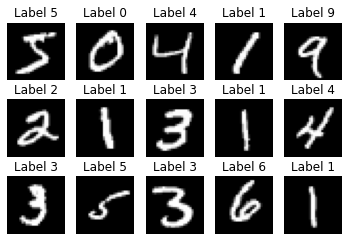

In [ ]:
plot_digits(mnist_X_train[:15],mnist_y_train[:15],(3,5))

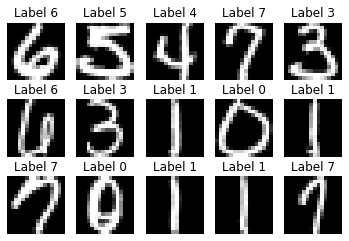

In [ ]:
plot_digits(usps_X_train[:15],usps_y_train[:15],(3,5))

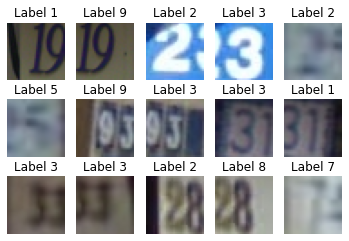

In [ ]:
plot_color_digits(svhn_X_train[:15] / 255,svhn_y_train[:15],(3,5))

**Data Preprocessing**

In [ ]:
mnist_0_4 = np.nonzero(mnist_y_train < 5)[0]
mnist_5_9 = np.nonzero(mnist_y_train >= 5)[0]
usps_0_4 = np.nonzero(usps_y_train < 5)[0]
usps_5_9 = np.nonzero(usps_y_train >= 5)[0]
svhn_0_4 = np.nonzero(svhn_y_train < 5)[0]
svhn_5_9 = np.nonzero(svhn_y_train >= 5)[0]
semeion_0_4 = np.nonzero(semeion_y_train < 5)[0]
semeion_5_9 = np.nonzero(semeion_y_train >= 5)[0]

In [ ]:
mnist_0_4t = np.nonzero(mnist_y_test < 5)[0]
mnist_5_9t = np.nonzero(mnist_y_test >= 5)[0]
usps_0_4t = np.nonzero(usps_y_test < 5)[0]
usps_5_9t = np.nonzero(usps_y_test >= 5)[0]
svhn_0_4t = np.nonzero(svhn_y_test < 5)[0]
svhn_5_9t = np.nonzero(svhn_y_test >= 5)[0]
semeion_0_4t = np.nonzero(semeion_y_test < 5)[0]
semeion_5_9t = np.nonzero(semeion_y_test >= 5)[0]

**Image Resize**

In [ ]:
mnist_X_train = mnist_X_train[:, :, :, np.newaxis]
mnist_X_train = tf.broadcast_to(mnist_X_train, mnist_X_train.shape[:-1] + (3,))
mnist_X_train = tf.image.resize(mnist_X_train, (32,32))

In [ ]:
mnist_X_train.shape

TensorShape([60000, 32, 32, 3])

In [ ]:
usps_X_train = usps_X_train[:, :, :, np.newaxis]
usps_X_train = tf.broadcast_to(usps_X_train, usps_X_train.shape[:-1] + (3,))
usps_X_train = tf.image.resize(usps_X_train, (32,32))

In [ ]:
usps_X_train.shape

TensorShape([7291, 32, 32, 3])

In [ ]:
svhn_X_train = tf.cast(tf.convert_to_tensor(svhn_X_train),'float32')
svhn_X_train.shape

TensorShape([73257, 32, 32, 3])

In [ ]:
mnist_X_test = mnist_X_test[:, :, :, np.newaxis]
mnist_X_test = tf.broadcast_to(mnist_X_test, mnist_X_test.shape[:-1] + (3,))
mnist_X_test = tf.image.resize(mnist_X_test, (32,32))

In [ ]:
mnist_X_test.shape

TensorShape([10000, 32, 32, 3])

In [ ]:
usps_X_test = usps_X_test[:, :, :, np.newaxis]
usps_X_test = tf.broadcast_to(usps_X_test, usps_X_test.shape[:-1] + (3,))
usps_X_test = tf.image.resize(usps_X_test, (32,32))

In [ ]:
usps_X_test.shape

TensorShape([2007, 32, 32, 3])

In [ ]:
svhn_X_test = tf.cast(tf.convert_to_tensor(svhn_X_test),'float32')
svhn_X_test.shape

TensorShape([26032, 32, 32, 3])

In [ ]:
semeion_X_train = semeion_X_train[:, :, :, np.newaxis]
semeion_X_train = tf.broadcast_to(semeion_X_train, semeion_X_train.shape[:-1] + (3,))
semeion_X_train = tf.image.resize(semeion_X_train, (32,32))

In [ ]:
semeion_X_train.shape

TensorShape([1274, 32, 32, 3])

In [ ]:
semeion_X_test = semeion_X_test[:, :, :, np.newaxis]
semeion_X_test = tf.broadcast_to(semeion_X_test, semeion_X_test.shape[:-1] + (3,))
semeion_X_test = tf.image.resize(semeion_X_test, (32,32))

In [ ]:
semeion_X_test.shape

TensorShape([319, 32, 32, 3])

**Data Scaling**

In [ ]:
tf.math.reduce_min(mnist_X_train), tf.math.reduce_max(mnist_X_train)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=255.0>)

In [ ]:
tf.math.reduce_min(usps_X_train), tf.math.reduce_max(usps_X_train)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.0>)

In [ ]:
tf.math.reduce_min(svhn_X_train), tf.math.reduce_max(svhn_X_train)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=255.0>)

In [ ]:
mnist_X_train = mnist_X_train / 255.0
svhn_X_train = svhn_X_train / 255.0

In [ ]:
tf.math.reduce_min(mnist_X_train), tf.math.reduce_max(mnist_X_train)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.0>)

In [ ]:
tf.math.reduce_min(svhn_X_train), tf.math.reduce_max(svhn_X_train)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.0>)

In [ ]:
mnist_X_test = mnist_X_test / 255.0
svhn_X_test = svhn_X_test / 255.0

In [ ]:
tf.math.reduce_min(mnist_X_test), tf.math.reduce_max(mnist_X_test)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.0>)

In [ ]:
tf.math.reduce_min(svhn_X_test), tf.math.reduce_max(svhn_X_test)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.0>)

In [ ]:
tf.math.reduce_min(semeion_X_train), tf.math.reduce_max(semeion_X_train)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.0>)

**Data Normalization**

In [ ]:
mnist_train_mean = np.mean(mnist_X_train,)
mnist_train_std  = np.std(mnist_X_train)
# Centering
# mnist_X_train    = mnist_X_train - mnist_train_mean
# mnist_X_test     = mnist_X_test - mnist_train_mean

# Standardization
# mnist_X_train    = mnist_X_train / mnist_train_std
# mnist_X_test     = mnist_X_test / mnist_train_std

In [ ]:
mnist_train_mean, mnist_train_std

(0.13085152, 0.28923184)

In [ ]:
usps_train_mean = np.mean(usps_X_train)
usps_train_std  = np.std(usps_X_train)
# Centering
# usps_X_train    = usps_X_train - usps_train_mean
# usps_X_test     = usps_X_test - usps_train_mean

# Standardization
# usps_X_train    = usps_X_train / usps_train_std
# usps_X_test     = usps_X_test / usps_train_std

In [ ]:
usps_train_mean, usps_train_std

(0.2544808, 0.3481659)

In [ ]:
svhn_train_mean = np.mean(svhn_X_train)
svhn_train_std  = np.std(svhn_X_train)
# Centering
# svhn_X_train    = svhn_X_train - svhn_train_mean
# svhn_X_test     = svhn_X_test - svhn_train_mean

# Standardization
# svhn_X_train    = svhn_X_train / svhn_train_std
# svhn_X_test     = svhn_X_test / svhn_train_std

In [ ]:
svhn_train_mean, svhn_train_std

(0.45141736, 0.1992912)

In [ ]:
mnist_train_mean = 0.0
mnist_train_std  = 1.0
usps_train_mean = 0.0
usps_train_std  = 1.0
svhn_train_mean = 0.0
svhn_train_std  = 1.0

# **Model Components**

**Feature Encoder Network**

In [ ]:
def FeatureEncoder(name=None):
    '''
    Return a Feature Encoder.
    '''
    fe_input = keras.Input(shape=(32,32,3))
    x = keras.layers.Dropout(0.2)(fe_input)
    x = keras.layers.Conv2D(filters=64, kernel_size=5, strides=1,
                                   padding='valid', activation='relu')(x)
    x = keras.layers.MaxPooling2D(2, strides=2)(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Conv2D(filters=64, kernel_size=5, strides=1,
                                   padding='valid', activation='relu')(x)
    x = keras.layers.MaxPooling2D(2, strides=2)(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Conv2D(filters=128, kernel_size=5, strides=1,
                                   padding='valid', activation='relu')(x)
    fe_out = keras.layers.Flatten()(x)
    if (name is None):
        fe = keras.Model(inputs=fe_input, outputs=fe_out, name='FeatureExtractor')
    else:
        fe = keras.Model(inputs=fe_input, outputs=fe_out, name=name)
    return fe

In [ ]:
fe_demo = FeatureEncoder()
fe_demo.summary()

Model: "FeatureExtractor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 64)        102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)     

**Classification Network**

In [ ]:
def ClassificationNet(name=None):
    '''
    Return a Classification Network.
    Input: None.
    Output: A tuple containing the handle of input layer and output layer.
    '''
    cl_input = keras.Input(shape=[128])
    x = keras.layers.Dense(128, activation='relu')(cl_input)
    cl_out = keras.layers.Dense(5, activation='relu')(x)
    if (name is None):
        cl = keras.Model(inputs=cl_input, outputs=cl_out, name='ClassificationNetwork')
    else:
        cl = keras.Model(inputs=cl_input, outputs=cl_out, name=name)
    return cl

In [ ]:
cl_demo = ClassificationNet()
cl_demo.summary()

Model: "ClassificationNetwork"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
Total params: 17,157
Trainable params: 17,157
Non-trainable params: 0
_________________________________________________________________


**Source Domain Decoder and Discriminator**

In [ ]:
def SourceTargetDecoder(name=None):
    dc_input = keras.Input(shape=[128])
    x = keras.layers.Reshape((1,1,128))(dc_input)
    # ConvTran,  2×2 , 512, stride 1, padding 0, Batch Normalization, ReLU
    x = keras.layers.Conv2DTranspose(filters=512, kernel_size=2, strides=1,
                                     padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    # ConvTran,  4×4 , 256, stride 2, padding 1, Batch Normalization, ReLU
    x = keras.layers.Conv2DTranspose(filters=256, kernel_size=4, strides=2,
                                     padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    # ConvTran,  4×4 , 128, stride 2, padding 1, Batch Normalization, ReLU
    x = keras.layers.Conv2DTranspose(filters=128, kernel_size=4, strides=2,
                                     padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    # ConvTran,  4×4 , 64, stride 2, padding 1, Batch Normalization, ReLU
    x = keras.layers.Conv2DTranspose(filters=64, kernel_size=4, strides=2,
                                     padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    # ConvTran,  4×4 , 3, stride 2, padding 1, Tanh
    dc_out = keras.layers.Conv2DTranspose(filters=3, kernel_size=4, strides=2,
                                          padding='same', activation="tanh")(x)
    if (name is None):
        dc = keras.Model(inputs=dc_input, outputs=dc_out, name='Decoder')
    else:
        dc = keras.Model(inputs=dc_input, outputs=dc_out, name=name)
    return dc

In [ ]:
def SourceDomainDiscriminator(name=None):
    '''
    Return a Source Domain Discriminator.
    Input: None.
    Output: A tuple containing the handle of input layer and output layer.
    '''
    sd_input = keras.Input((32,32,3))
    x = keras.layers.Conv2D(filters=64, kernel_size=3, strides=1,
                            padding='same')(sd_input)
    x = keras.layers.LeakyReLU(alpha=0.2)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPool2D(2, strides=2)(x)
    x = keras.layers.Conv2D(filters=128, kernel_size=3, strides=1,
                        padding='same')(x)
    x = keras.layers.LeakyReLU(alpha=0.2)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPool2D(2, strides=2)(x)
    x = keras.layers.Conv2D(filters=256, kernel_size=3, strides=1,
                        padding='same')(x)
    x = keras.layers.LeakyReLU(alpha=0.2)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPool2D(4, strides=4)(x)
    x = keras.layers.Flatten()(x)
    sd_out_bin = keras.layers.Dense(1, activation='sigmoid')(x)
    sd_out_aux = keras.layers.Dense(5, activation='relu')(x)
    if (name is None):
        sd = keras.Model(inputs=sd_input, outputs=(sd_out_bin, sd_out_aux),
                         name='SourceDomainDiscriminator')
    else:
        sd = keras.Model(inputs=sd_input, outputs=(sd_out_bin, sd_out_aux),
                         name=name)
    return sd

In [ ]:
src_input = keras.Input(shape=[128])
x = SourceTargetDecoder()(src_input)
src_out = SourceDomainDiscriminator()(x)

src_demo = keras.Model(inputs=src_input, outputs=src_out)
src_demo.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
Decoder (Functional)         (None, 32, 32, 3)         3022531   
_________________________________________________________________
SourceDomainDiscriminator (F ((None, 1), (None, 5))    378758    
Total params: 3,401,289
Trainable params: 3,398,473
Non-trainable params: 2,816
_________________________________________________________________


**Target Domain Decoder and Discriminator**

In [ ]:
def TargetDomainDiscriminator(name=None):
    td_input = keras.Input((32,32,3))
    x = keras.layers.Conv2D(filters=64, kernel_size=3, strides=1,
                        padding='same')(td_input)
    x = keras.layers.LeakyReLU(alpha=0.2)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPool2D(2, strides=2)(x)
    x = keras.layers.Conv2D(filters=128, kernel_size=3, strides=1,
                        padding='same')(x)
    x = keras.layers.LeakyReLU(alpha=0.2)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPool2D(2, strides=2)(x)
    x = keras.layers.Conv2D(filters=256, kernel_size=3, strides=1,
                        padding='same')(x)
    x = keras.layers.LeakyReLU(alpha=0.2)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPool2D(4, strides=4)(x)
    x = keras.layers.Flatten()(x)
    td_out = keras.layers.Dense(1, activation='sigmoid')(x)
    if (name is None):
        td = keras.Model(inputs=td_input, outputs=td_out, name='TargetDomainDiscriminator')
    else:
        td = keras.Model(inputs=td_input, outputs=td_out, name=name)
    return td

In [ ]:
tgt_input = keras.Input(shape=[128])
x = SourceTargetDecoder()(tgt_input)
tgt_out = TargetDomainDiscriminator()(x)

tgt_demo = keras.Model(inputs=tgt_input, outputs=tgt_out)
tgt_demo.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
Decoder (Functional)         (None, 32, 32, 3)         3022531   
_________________________________________________________________
TargetDomainDiscriminator (F (None, 1)                 373633    
Total params: 3,396,164
Trainable params: 3,393,348
Non-trainable params: 2,816
_________________________________________________________________


# **Compose the Model**

**ALOCC Wiring**

In [ ]:
# Build Model
optimizer = keras.optimizers.RMSprop(lr=0.002, clipvalue=1.0, decay=1e-8)

# Input layer
prop_input_tgt = keras.Input(shape=(32,32,3), name="TargetInput")
    
# Fed to the generator
prop_fe = FeatureEncoder()
prop_fe_tgt = prop_fe(prop_input_tgt)
prop_sd = SourceTargetDecoder()
reconstructed_img = prop_sd(prop_fe_tgt)

# Target flow to the target domain discriminator
prop_tdd = TargetDomainDiscriminator()
prop_tdd.compile(optimizer=optimizer,loss='binary_crossentropy')
prop_tdd.trainable = False
validity = prop_tdd(reconstructed_img)

# Final model
mod_alocc = keras.Model(
    inputs=[prop_input_tgt],
    outputs=[reconstructed_img, validity]
)
mod_alocc.compile(loss=['binary_crossentropy', 'binary_crossentropy'],
            loss_weights=[0.2, 1],
            optimizer=optimizer)

In [ ]:
def train_alocc_model(model,X_tgt, optimizer, batch_size=64, n_epochs=50, name=None):
    X_tilde = X_tgt + torch.randn((len(X_tgt),32,32,3))

    counter = 1
    # Record generator/R network reconstruction training losses.
    plot_epochs = []
    plot_g_recon_losses = []
    
    # Adversarial ground truths
    ones = np.ones((batch_size, 1))
    zeros = np.zeros((batch_size, 1))
    for epoch in range(1, n_epochs + 1):
        n_steps = len(X_tgt) // batch_size
        for idx in range(0, n_steps):
            batch = X_tgt[idx * batch_size:(idx + 1) * batch_size]
            batch_noise = X_tilde[idx * batch_size:(idx + 1) * batch_size]
            batch_clean = X_tgt[idx * batch_size:(idx + 1) * batch_size]
            
            batch_images = np.array(batch).astype(np.float32)
            batch_noise_images = np.array(batch_noise).astype(np.float32)
            batch_clean_images = np.array(batch_clean).astype(np.float32)

            outputs = model((batch_noise_images), training=True)
            (reconstructed_img, validity) = outputs
            
            batch_fake_images = reconstructed_img
            # Update D network
            d_loss_real = prop_tdd.train_on_batch(batch_images,ones)
            d_loss_fake = prop_tdd.train_on_batch(batch_fake_images,zeros)
            
            # Update R network
            model.train_on_batch(batch_noise_images, [batch_clean_images, ones])
            g_loss = model.train_on_batch(batch_noise_images, [batch_clean_images, ones])
            loss = g_loss
            plot_epochs.append(epoch+idx/n_steps)
            plot_g_recon_losses.append(g_loss[1])
            counter += 1
        msg = "Epoch:[{0}] --> d_loss: {1:>0.3f}, g_loss:{2:>0.3f}, g_recon_loss:{3:>0.3f}".format(epoch,d_loss_real+d_loss_fake, g_loss[0], g_loss[1])
        print(msg)
    # Save the model at this epoch
    model.save('ALOCC_'+ name + '_epoch_' + str(epoch) + time.strftime("_%Y_%m_%d-%H_%M_%S"))

**Helper Functions**

In [ ]:
def random_batch(X, y, batch_size=32):
    idx = np.random.randint(len(X), size=batch_size)
    return tf.gather(X, idx), tf.gather(y, idx)

In [ ]:
def print_status_bar(iteration, total, loss=None):
    if (loss is not None):
        metrics = " - ".join(["{}: {:.4f}".format(m.name, m.result())
                             for m in loss])
    else:
        metrics = 'No loss available'
    end = "" if iteration < total else "\n"
    print("\r{}/{} - ".format(iteration, total) + metrics,
          end=end)

In [ ]:
def plot_auc_curve(fpr, tpr, ax):
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color='darkorange',
             lw=2.0, label='ROC curve (area = %0.3f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color='gray', lw=1.0, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")

In [ ]:
def novelty_detector(model, X, c_softmax=1.0, c_gloss=1.0, c_dscore=1.0):
    '''
    A novelty detector based on proposed method. Output a score based on maximum softmax probability,
    generator loss, and discriminator score.
    '''
    batch_size = 64
    n_batch = len(X) // batch_size
    discriminator_score = np.array([]).reshape(0)

    print('Novelty Detector - Computing Outputs')
    
    for i in range(n_batch):
        s = i * batch_size
        e = (i+1) * batch_size
        outputs = mod_alocc((X[s:e]))
        (reconstructed_img, validity) = outputs

        discriminator_score = np.concatenate((discriminator_score,
            tf.squeeze(validity)))
        
        print_status_bar(i * batch_size, len(X))
    
    s = n_batch * batch_size
    e = len(X)
    outputs = mod_alocc((X[s:e]))
    (reconstructed_img, validity) = outputs

    discriminator_score = np.concatenate((discriminator_score,
        tf.squeeze(validity)))
    
    print_status_bar(len(X), len(X))
    
    return (discriminator_score)

# **MNIST to USPS**

In [ ]:
X_tgt_1 = tf.gather(mnist_X_train, mnist_0_4)
history = train_alocc_model(mod_alocc,X_tgt_1,optimizer,batch_size=10, n_epochs=5, name='mnist_usps')

Epoch:[1] --> d_loss: 0.000, g_loss:0.035, g_recon_loss:0.175
Epoch:[2] --> d_loss: 0.000, g_loss:0.083, g_recon_loss:0.263
Epoch:[3] --> d_loss: 0.000, g_loss:0.029, g_recon_loss:0.147
Epoch:[4] --> d_loss: 0.000, g_loss:0.030, g_recon_loss:0.148
Epoch:[5] --> d_loss: 0.000, g_loss:0.031, g_recon_loss:0.155
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ALOCC_mnist_usps_epoch_5_2020_12_07-01_09_13/assets


In [ ]:
mod_saved = tf.keras.models.load_model('ALOCC_mnist_usps_epoch_5_2020_12_06-22_50_36')

In [ ]:
X_origin = tf.gather(usps_X_train, usps_0_4)
X_novel = tf.gather(usps_X_train, usps_5_9)
len_origin = len(X_origin)
len_novel = len(X_novel)
X_tgt = tf.concat((X_origin, X_novel), axis=0)
y_tgt = tf.constant([[0.]] * len_origin + [[1.]] * len_novel)
y_score = novelty_detector(mod_saved, X_tgt)

Novelty Detector - Computing Outputs
7291/7291 - No loss available


Text(0.5, 1.0, 'ALOCC MNIST to USPS Overall Score')

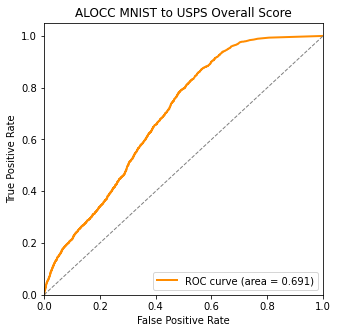

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
fpr, tpr, _  = roc_curve(y_tgt, -y_score)
plot_auc_curve(fpr, tpr, ax)
ax.set_title('ALOCC MNIST to USPS Overall Score')

# **SVHN to MNIST Case**

In [ ]:
X_tgt_2 = tf.gather(svhn_X_train, svhn_0_4)
history2 = train_alocc_model(mod_alocc,X_tgt_2,optimizer,batch_size=10, n_epochs=5, name='svhn_mnist')

In [ ]:
mod_saved_2 = tf.keras.models.load_model('ALOCC_svhn_mnist_epoch_5_2020_12_07-00_32_07')

In [ ]:
X_origin = tf.gather(mnist_X_train, mnist_0_4)
X_novel = tf.gather(mnist_X_train, mnist_5_9)
len_origin = len(X_origin)
len_novel = len(X_novel)
X_tgt = tf.concat((X_origin, X_novel), axis=0)
y_tgt = tf.constant([[0.]] * len_origin + [[1.]] * len_novel)
y_score = novelty_detector(mod_saved_2, X_tgt)

Novelty Detector - Computing Outputs
60000/60000 - No loss available


Text(0.5, 1.0, 'ALOCC SVHN to MNIST Overall Score')

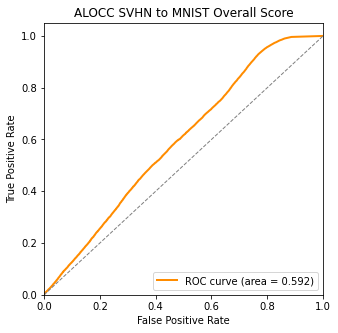

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
fpr, tpr, _  = roc_curve(y_tgt, -y_score)
plot_auc_curve(fpr, tpr, ax)
ax.set_title('ALOCC SVHN to MNIST Overall Score')

# **SVHN to USPS**

In [ ]:
mod_saved_2 = tf.keras.models.load_model('ALOCC_svhn_mnist_epoch_5_2020_12_06-23_30_52')

In [ ]:
X_origin = tf.gather(usps_X_train, usps_0_4)
X_novel = tf.gather(usps_X_train, usps_5_9)
len_origin = len(X_origin)
len_novel = len(X_novel)
X_tgt = tf.concat((X_origin, X_novel), axis=0)
y_tgt = tf.constant([[0.]] * len_origin + [[1.]] * len_novel)
y_score = novelty_detector(mod_saved_2, X_tgt)

Novelty Detector - Computing Outputs
7291/7291 - No loss available


Text(0.5, 1.0, 'ALOCC SVHN to USPS Overall Score')

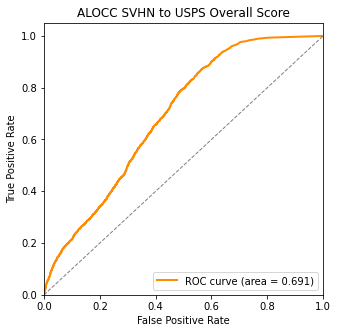

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
fpr, tpr, _  = roc_curve(y_tgt, -y_score)
plot_auc_curve(fpr, tpr, ax)
ax.set_title('ALOCC SVHN to USPS Overall Score')

# **USPS to MNIST**

In [ ]:
X_tgt_3 = tf.gather(usps_X_train, usps_0_4)
history3 = train_alocc_model(mod_alocc,X_tgt_3,optimizer,batch_size=10, n_epochs=5, name='usps_mnist')

Epoch:[1] --> d_loss: 0.000, g_loss:0.219, g_recon_loss:1.093
Epoch:[2] --> d_loss: 0.000, g_loss:0.145, g_recon_loss:0.723
Epoch:[3] --> d_loss: 0.000, g_loss:0.144, g_recon_loss:0.707
Epoch:[4] --> d_loss: 9.351, g_loss:3.374, g_recon_loss:0.695
Epoch:[5] --> d_loss: 0.000, g_loss:0.098, g_recon_loss:0.491
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ALOCC_usps_mnist_epoch_5_2020_12_07-01_21_51/assets


In [ ]:
mod_saved_3 = tf.keras.models.load_model('ALOCC_usps_mnist_epoch_5_2020_12_07-01_21_51')

In [ ]:
X_origin = tf.gather(mnist_X_train, mnist_0_4)
X_novel = tf.gather(mnist_X_train, mnist_5_9)
len_origin = len(X_origin)
len_novel = len(X_novel)
X_tgt = tf.concat((X_origin, X_novel), axis=0)
y_tgt = tf.constant([[0.]] * len_origin + [[1.]] * len_novel)
y_score = novelty_detector(mod_saved_3, X_tgt)

Novelty Detector - Computing Outputs
60000/60000 - No loss available


Text(0.5, 1.0, 'ALOCC USPS to MNIST Overall Score')

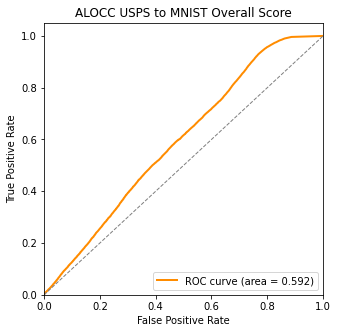

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
fpr, tpr, _  = roc_curve(y_tgt, -y_score)
plot_auc_curve(fpr, tpr, ax)
ax.set_title('ALOCC USPS to MNIST Overall Score')